# Droplet Spreading over a spherical surface
![Spherical_spreading domain configuration](SphericalSpreading.png)


In this study, we consider a droplet spreading over a spherical surface for a very small Bond number ($Bo\ll1$), as described in [patel2017coupled](https://doi.org/10.1016/j.ces.2017.03.012) . This case study allows studying the spreading of a droplet over a complex surface discretized using an unstructured Cartesian three-dimensional mesh refined locally around the spherical object.  Ideally, for a droplet that spreads with $Bo\ll1$, surface tension forces dominate, and the droplet at equilibrium maintains a spherical cap shape and satisfies the contact angle boundary condition.

Volume: 4.188790204786391e-09


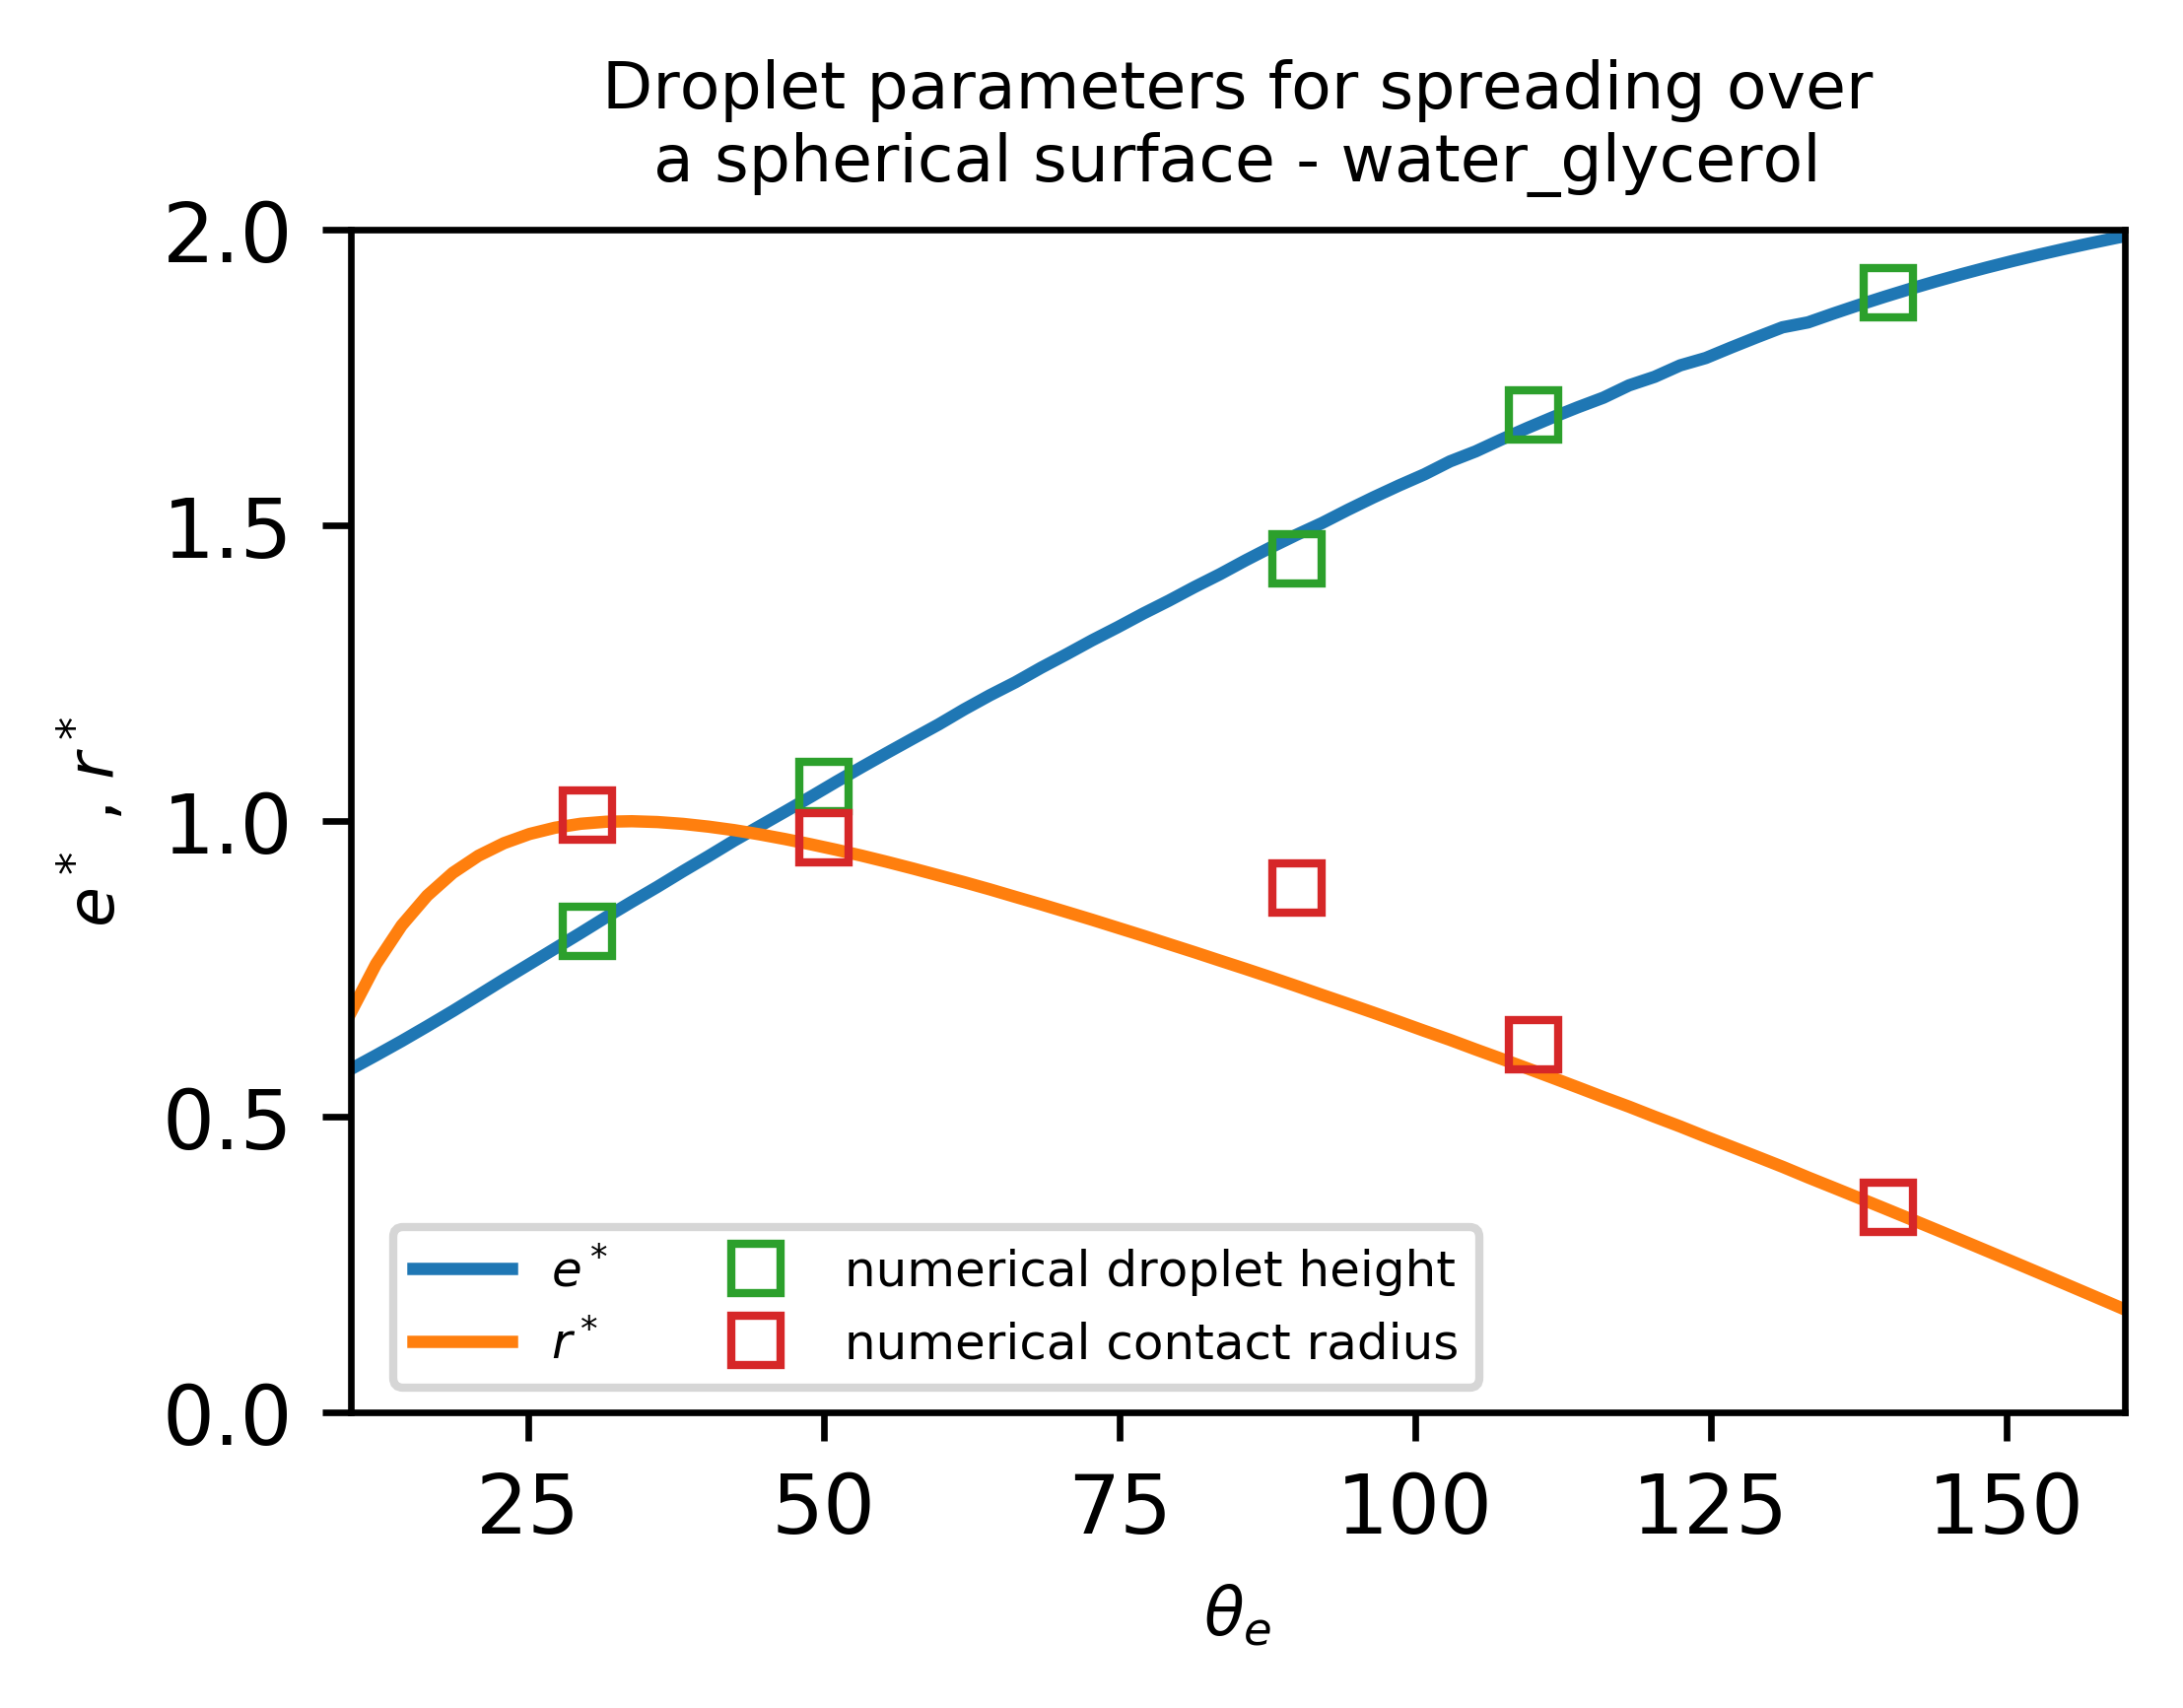

Note: for contact angle 90, the droplet spreads asymmetrically caused by the numerical noise.


In [1]:
#Assumptions: 
#1.  z-axis is the height of the domain. 
#2.  if geometry changes, change the height of the sphere for droplet height calculations 

import numpy as np
from scipy.optimize import fsolve
import math
import sys
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os
import csv
import vtk
sys.path.append(os.path.join(os.getcwd(), '../modules'))
from spherical_spreading_funcs import Funcs
###################################################################################################################

sin =np.sin
cos= np.cos
pi = np.pi

#Degree range (x-axis)
thetaDeg =np.linspace(10, 170, 75) 
R0 = 0.001
V = 4/3*pi*R0**3
print("Volume: " + str(V))
eps = 1e-10
heightOfSphere = 0.00167581

rcParams["figure.dpi"] = 600
fontSize =8
calcHeights = False #True if the simulations are run again and need to write the height.csv from vtk files
###################################################################################################################

hf = [Funcs.getAngles(val,V,R0)[0] for idx, val in enumerate(thetaDeg)]
rf = [Funcs.getAngles(val,V,R0)[1] for idx, val in enumerate(thetaDeg)]

###################################################################################################################
## File structure (absolute working driectory)

simStaticCAList= [] # static contact angles used for simulations taken from the variation file
stm = [] # surface tension models in all cases,taken from the variation file
var_list = [] # variance number of the parametric study of a specific case
surfaceTensionModel = 'fitParaboloid' #surface tension model chosen for the simulations {heightFunction, RDF, fitParaboloid}
    
#variables for plots for silicon oil
pattern = 'test_' #parametric file labels -> NSfiner_ for perfect wetting
dataFolder = '/postProcessing/' #folder with .csv files

#read the variation-file to get the parameters map that is saved using pyFOAM
var_Map = Funcs.fileMapping(pattern, surfaceTensionModel)  
     
for key, value in var_Map.items():
    stm_map = str(value).split(', ')[0][:-1] #surface tension model map
    stm.append(stm_map.split(': ')[1][1:])
    theta_map = str(value).split(', ')[1][:-1] #contact angle map
    #print(theta_map)
    simStaticCAList.append(int(theta_map.split(': ')[1][0:]))
    var_list.append(str(key))  

##################################################################################################################
#File names
vtk_folders = Funcs.fileStructure(dataFolder, 'surfaces/', pattern, var_list)
heightFileNames = Funcs.fileStructure(dataFolder, 'height.csv', pattern,var_list)
rfMaxFileNames = Funcs.fileStructure(dataFolder, 'rfMax.csv', pattern, var_list )

 #Calculates the height of the the droplet from vtk files and stores in the respective height.csv file in each simulation folder
Funcs.writeHeightFile(calcHeights,vtk_folders, heightFileNames)
##################################################################################################################

plotLabels = [r"numerical droplet height", r"numerical contact radius"]
#Plot equilibrium spread against static contact angle
fig = plt.figure()
myaxes = fig.add_axes([0.1, 0.1, 0.5, 0.5])
plt.plot(thetaDeg, hf, label=r'$e^*$')
plt.plot(thetaDeg, rf, label=r'$r^*$')
plt.title(r'Droplet parameters for spreading over'+'\n' +r'a spherical surface - water_glycerol', fontsize=fontSize)
plt.xlabel(r'$\theta_e$' ,color='black',fontsize=fontSize)
plt.ylabel(r'$e^*$ , $r^*$',color='black',fontsize=fontSize)

equilibriumhfList= [None] *len(simStaticCAList)

nPointsForHeightAverage = 2
for idx, heightFile in enumerate(heightFileNames):
    avgHeight = 0
    for i in range(1, nPointsForHeightAverage):
        with open(heightFileNames[idx], "r") as f1:
            last_line = f1.readlines()[-i]
            avgHeight += (float(last_line.rsplit(',', 1)[1]) - heightOfSphere)

    avgHeight /= (nPointsForHeightAverage-1)
    equilibriumhfList[idx] = (avgHeight /R0 ) 

plt.plot(simStaticCAList, equilibriumhfList, marker='s', markerfacecolor='None',linestyle = 'None', label=plotLabels[0])
equilibriumrfList= [None] *len(simStaticCAList)
for idx, rfFile in enumerate(rfMaxFileNames):
    with open(rfMaxFileNames[idx], "r") as f1:
        last_line = f1.readlines()[-1]
        #print(last_line.rsplit(',', 1)[1])
        equilibriumrfList[idx] =(float(last_line.rsplit(',', 1)[1])/R0)

plt.plot(simStaticCAList, equilibriumrfList, marker='s', markerfacecolor='None', linestyle = 'None', label=plotLabels[1])

plt.ylim([0, 2])
plt.xlim([10, 160])
plt.legend(fontsize=6, loc='lower center', bbox_to_anchor=(0.33, 0), ncol=2)
plt.savefig('spherical-droplet-spreading-chractersitics-against-static-contact-angle-'+str(surfaceTensionModel)+'.pdf', bbox_inches='tight')
plt.savefig('spherical-droplet-spreading-chractersitics-against-static-contact-angle-'+str(surfaceTensionModel)+'.png', bbox_inches='tight')
plt.show()

print('Note: for contact angle 90, the droplet spreads asymmetrically caused by the numerical noise.')